In [88]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
import scikitplot as skplt
from matplotlib.colors import ListedColormap
# cmap = ListedColormap(sns.color_palette("husl", len(gs.classes_)))
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.preprocessing import PowerTransformer

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [11]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine

# DSN (data source name) format for database connections:  
# [protocol / database  name]://[username]:[password]@[hostname / ip]:[port]/[database name here]


# on your computer you are the user postgres (full administrative access)
db_user = 'postgres'
# if you need a password to access a database, put it here
db_password = ''
# on your computer, use localhost
db_host = 'localhost'
# the default port for postgres is 5432
db_port = 5432
# we want to connect to the northwind database
database = 'FBREF2'

conn_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}'      
engine = create_engine(conn_str+f'/{database}')
conn = engine.connect()
conn.execute("commit")
try:
    conn.execute(f'create database {database}')
except:
    print('database already exists')
conn.close() 

database already exists


In [12]:
def q(query):
    x = pd.read_sql(query, engine)
    return x

huge = q('''SELECT * FROM huge''')


In [13]:
columns_to_drop = []
for col in list(huge.columns):
    if 'home_conceded' in col:
        columns_to_drop.append(col)
    elif 'away_conceded' in col:
        columns_to_drop.append(col)
    elif 'home_xG' in col:
        columns_to_drop.append(col)
    elif 'away_xG' in col:
        columns_to_drop.append(col)
#     elif 'Pos' in col:
#         columns_to_drop.append(col)
    elif 'captain' in col:
        columns_to_drop.append(col)
    elif 'Home_manager' == col:
        columns_to_drop.append(col)
    elif 'Away_manager' == col:
        columns_to_drop.append(col)
    elif 'Date' in col:
        columns_to_drop.append(col)
    elif 'team' == col:
        columns_to_drop.append(col)
    elif 'Home_team' == col:
        columns_to_drop.append(col)
    elif 'Away_team' == col:
        columns_to_drop.append(col)
    elif 'Player' == col:
        columns_to_drop.append(col)
    elif 'ame_id' in col:
         columns_to_drop.append(col)
        



for i in range(1,8):
    columns_to_drop.append(f'att_player{i}')
    columns_to_drop.append(f'def_player{i}')

In [14]:
X = huge.drop(columns=[col for col in columns_to_drop])

X = pd.get_dummies(X, columns=['att_player1_Pos',
 'att_player2_Pos',
 'att_player3_Pos',
 'att_player4_Pos',
 'att_player5_Pos',
 'att_player6_Pos',
 'att_player7_Pos','Ref','Competition', 'att_team', 'def_team', 'att_manager', 'def_manager', 'def_player1_Pos',
 'def_player2_Pos',
 'def_player3_Pos',
 'def_player4_Pos',
 'def_player5_Pos',
 'def_player6_Pos',
 'def_player7_Pos',])

In [15]:
X = X.dropna()

X = X.copy()
y = X.pop('clean_sheets')

In [16]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from xgboost import XGBRFClassifier

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [27]:
scaler= StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=y_train.index)
X_test =  pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns, index=y_test.index)

In [48]:
pca = PCA(n_components=1682)
cols = ['PC_{}'.format(i) for i in range(1, pca.n_components+1)]
X_train_pca = pd.DataFrame(pca.fit_transform(X_train), columns=cols)
X_test_pca = pd.DataFrame(pca.transform(X_test), columns=cols)
X_train_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_1673,PC_1674,PC_1675,PC_1676,PC_1677,PC_1678,PC_1679,PC_1680,PC_1681,PC_1682
0,-1880.184849,-6.552416,-85.751375,21.653307,-14.894173,-10.752628,3.227046,-24.311890,20.247397,-13.113135,...,3.917708e-12,1.276146e-12,1.471360e-12,-2.732485e-12,-3.096123e-13,1.952202e-12,-9.557811e-13,-6.967535e-15,1.400095e-14,-8.179609e-15
1,-22701.219071,-58.109534,17.160066,17.637978,40.116694,-22.879130,-5.396719,18.349521,29.158160,30.288324,...,-1.936029e-12,-1.383223e-12,-4.294610e-13,3.440559e-13,1.861125e-13,1.452472e-13,6.656393e-14,8.585848e-15,3.220629e-15,-9.398258e-16
2,-4176.215186,-36.862526,22.217048,-2.409541,-40.081810,22.940073,4.281248,-0.036400,1.716245,-1.645913,...,-7.973691e-13,1.786089e-12,-2.164412e-13,-3.038041e-12,2.826317e-12,1.541670e-14,1.183422e-13,1.163152e-14,3.464935e-15,-1.322815e-15
3,8103.811039,5.892891,-39.760299,-20.382946,-35.591089,30.734077,-16.191365,-16.319982,-35.021159,-24.724389,...,1.384670e-12,-2.518423e-12,1.049089e-12,-4.397451e-13,-1.619876e-12,-4.306353e-12,-2.735749e-13,5.022550e-15,1.890434e-15,-1.408362e-15
4,-22701.166301,36.723261,18.191339,19.785610,23.963589,13.598145,-15.600121,-33.675187,57.305038,-26.830713,...,-2.082091e-12,2.271249e-12,-4.745402e-13,-1.842477e-13,2.268588e-12,-3.708928e-12,-1.259636e-13,3.089540e-15,9.815397e-15,-5.496444e-15


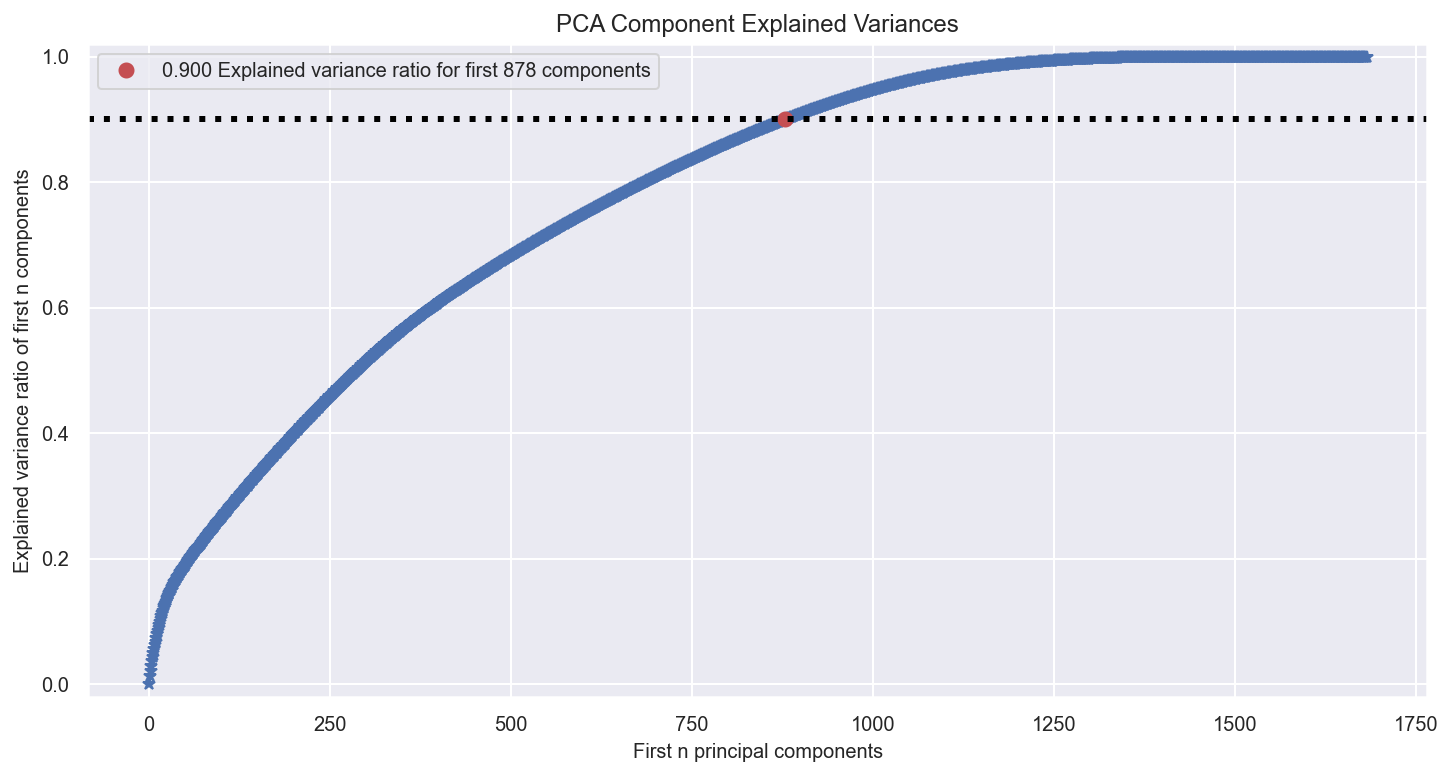

In [33]:
from scikitplot.decomposition import plot_pca_component_variance

plot_pca_component_variance(pca, target_explained_variance=0.90, figsize=(12, 6))
plt.show()

In [49]:
base_estimator = RandomForestClassifier(random_state=1, n_estimators=500, n_jobs=-1, verbose=1)

ada = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=1000,
                           random_state=1)
ada.fit(X_train_pca, y_train)
print('Training:', ada.score(X_train_pca, y_train))
print('Test:', ada.score(X_test_pca, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finis

Training: 1.0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s


Test: 0.7350845948352627


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


In [ ]:
Test: 0.7350845948352627

In [50]:
joblib.dump(ada, 'ada_pca_7351')

['ada_pca_7351']

In [40]:
joblib.dump(pipe_pca, 'ada_pca_smote_7306.jlb')

['ada_pca_smote_7306.jlb']

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finished


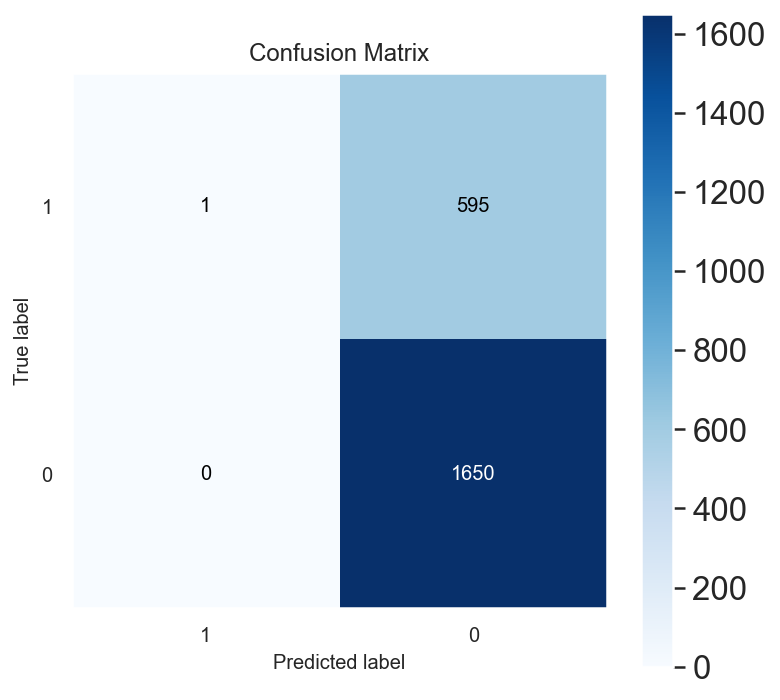

In [54]:
preds = ada.predict(X_test_pca)
skplt.metrics.plot_confusion_matrix(y_test, preds, labels=[1, 0], figsize=(6, 6))
plt.show()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


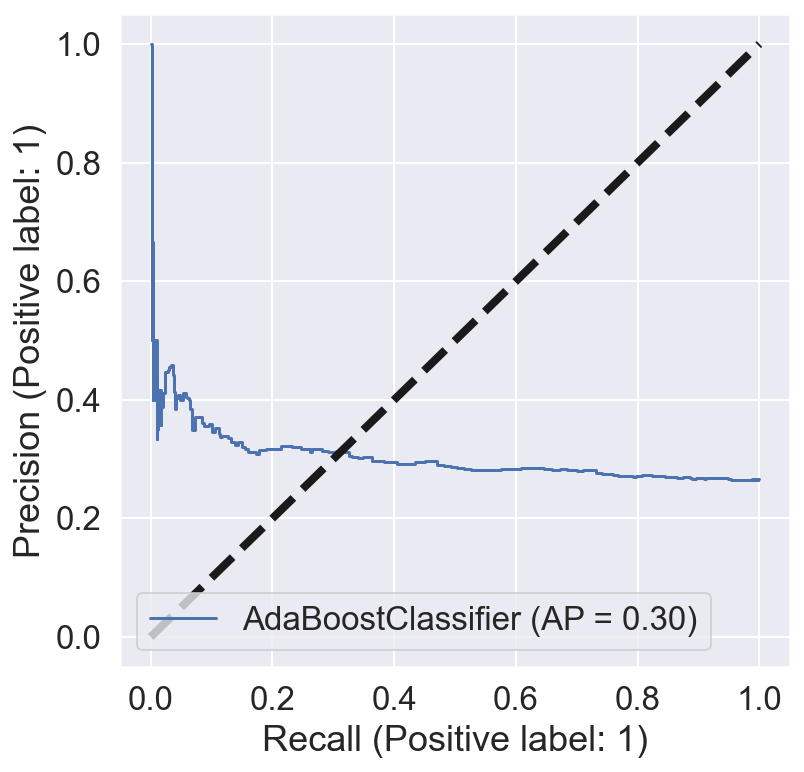

In [72]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(ada, X_test_pca, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

In [55]:
Y_pp = pd.DataFrame(ada.predict_proba(X_test_pca),
             columns=['class_0_pp', 'class_1_pp'])
Y_pp.head()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


,class_0_pp,class_1_pp
0,0.730,0.270
1,0.722,0.278
2,0.616,0.384
3,0.732,0.268
4,0.744,0.256


In [82]:
Y_pp = pd.DataFrame(ada.predict_proba(X_test_pca),
             columns=['class_0_pp', 'class_1_pp'])
Y_pp.head()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.8s finished


,class_0_pp,class_1_pp
0,0.730,0.270
1,0.722,0.278
2,0.616,0.384
3,0.732,0.268
4,0.744,0.256


In [87]:
sns.distplot(Y_pp.class_1_pp[y_testPCA == 1], rug=True, kde=False, norm_hist=True)
sns.distplot(Y_pp.class_1_pp[y_testPCA==0], rug=True, kde=False, norm_hist=True)
plt.show()

NameError: name 'y_testPCA' is not defined

In [74]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.45)

Y_pp.head(20)

,class_0_pp,class_1_pp,pred_class_thresh
0,0.730,0.270,0
1,0.722,0.278,0
2,0.616,0.384,0
3,0.732,0.268,0
4,0.744,0.256,0
5,0.570,0.430,0
6,0.558,0.442,0
7,0.724,0.276,0
8,0.556,0.444,0
9,0.702,0.298,0


In [70]:
print(classification_report(y_test, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.74      0.99      0.84      1650
           1       0.40      0.02      0.03       596

    accuracy                           0.73      2246
   macro avg       0.57      0.50      0.44      2246
weighted avg       0.65      0.73      0.63      2246



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


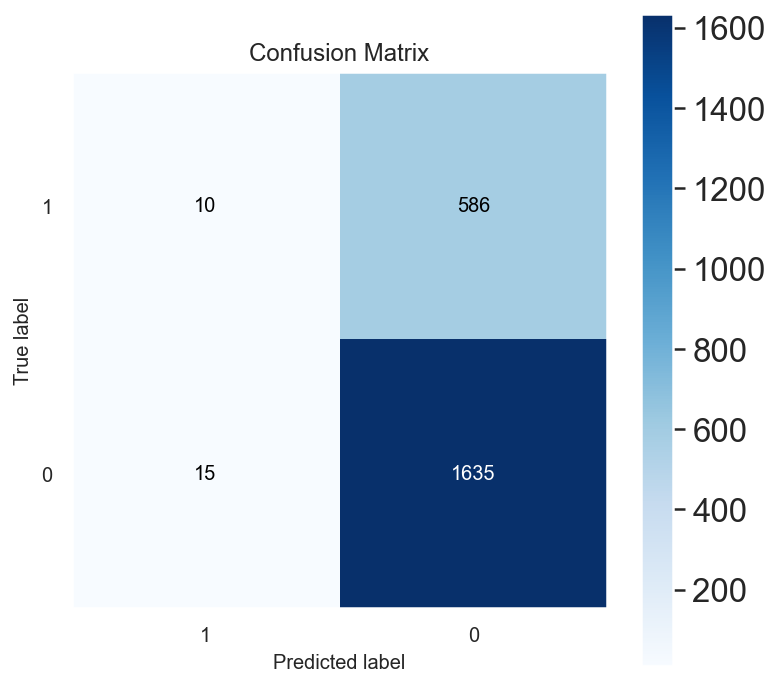

In [71]:
preds = ada.predict(X_test_pca)
skplt.metrics.plot_confusion_matrix(y_test, Y_pp.pred_class_thresh, labels=[1, 0], figsize=(6, 6))
plt.show()

In [90]:
base_estimator = RandomForestClassifier(random_state=1, n_estimators=500, n_jobs=-1, verbose=1)

categories = range(398, len(X_train.columns))

pipe_pca = Pipeline([('PCA', PCA(n_components=1682)),
                     ('pt', PowerTransformer()),
                    ('ada', AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=500,
                           random_state=1))])

pipe_pca.fit(X_train.values, y_train.values)
print('Training:', pipe_pca.score(X_train.values, y_train.values))
print('Test:', pipe_pca.score(X_test.values, y_test.values))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.3s finis

Training: 0.9779583658020706


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Test: 0.7355298308103295


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


In [ ]:
pipe_pca

In [46]:
base_estimator = RandomForestClassifier(random_state=1, n_estimators=500, n_jobs=-1, verbose=1)

categories = range(398, len(X_train.columns))

pipe_pca = Pipeline([('sm', SMOTENC(categorical_features=categories, n_jobs=-1)),
                     ('scaler', StandardScaler()),
                     ('PCA', PCA(n_components=1682)),
                    ('ada', AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=500,
                           random_state=1))])

pipe_pca.fit(X_train.values, y_train.values)
print('Training:', pipe_pca.score(X_train.values, y_train.values))
print('Test:', pipe_pca.score(X_test.values, y_test.values))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finis

Training: 1.0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Test: 0.7297417631344613


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


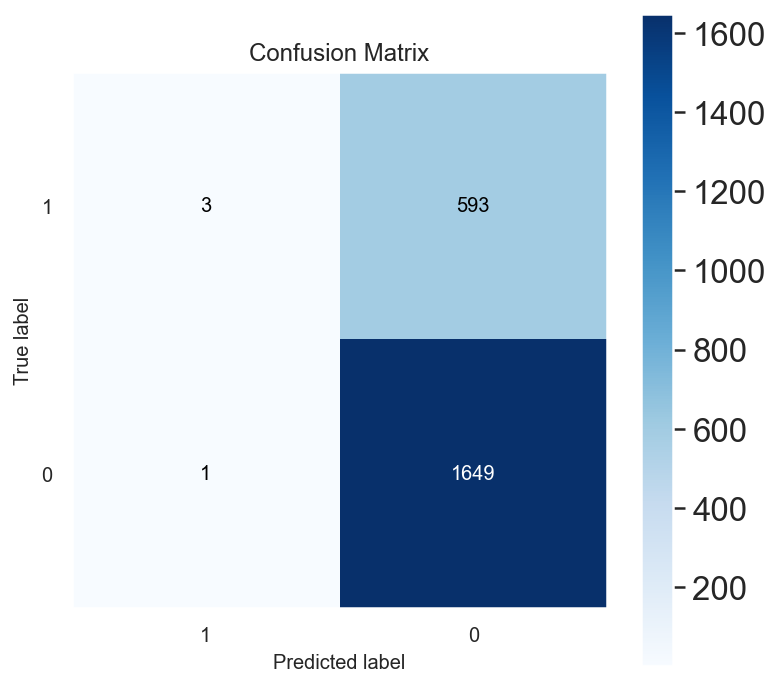

In [91]:
preds = pipe_pca.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, preds, labels=[1, 0], figsize=(6, 6))
plt.show()

In [94]:
Y_pp = pd.DataFrame(pipe_pca.predict_proba(X_test),
             columns=['class_0_pp', 'class_1_pp'])
Y_pp.head()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


,class_0_pp,class_1_pp
0,0.750,0.250
1,0.734,0.266
2,0.698,0.302
3,0.706,0.294
4,0.728,0.272


In [105]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.3)

Y_pp.head(20)

,class_0_pp,class_1_pp,pred_class_thresh
0,0.750,0.250,0
1,0.734,0.266,0
2,0.698,0.302,1
3,0.706,0.294,0
4,0.728,0.272,0
5,0.606,0.394,1
6,0.630,0.370,1
7,0.752,0.248,0
8,0.568,0.432,1
9,0.732,0.268,0


In [110]:
preds = pipe_pca.predict(X_test)
print(classification_report(y_test, preds))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s


              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1650
           1       0.75      0.01      0.01       596

    accuracy                           0.74      2246
   macro avg       0.74      0.50      0.43      2246
weighted avg       0.74      0.74      0.63      2246



[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished


In [106]:
print(classification_report(y_test, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.76      0.55      0.64      1650
           1       0.29      0.50      0.37       596

    accuracy                           0.54      2246
   macro avg       0.52      0.53      0.50      2246
weighted avg       0.63      0.54      0.57      2246



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


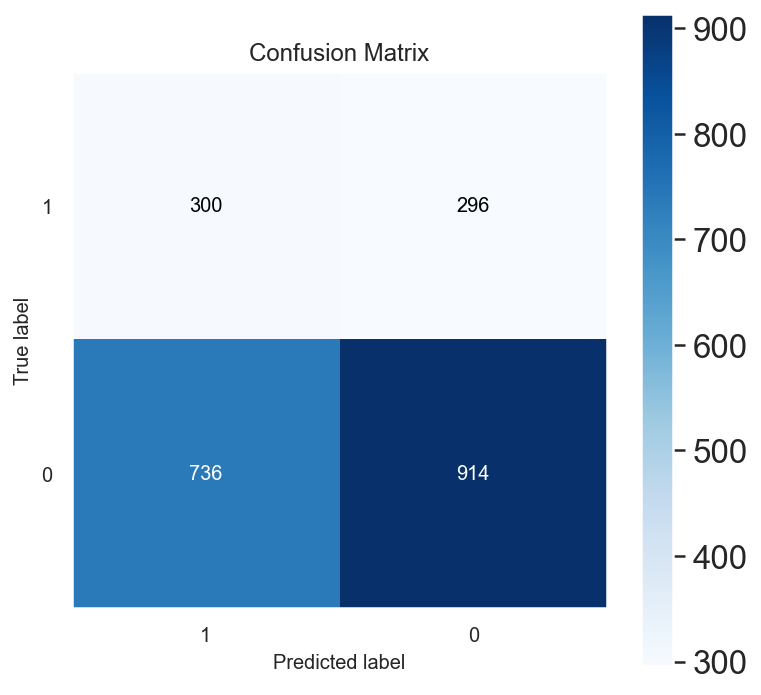

In [111]:
preds = ada.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, Y_pp.pred_class_thresh, labels=[1, 0], figsize=(6, 6))
plt.show()